In [89]:
from typing import Union, List, Union, Tuple, Optional
from matplotlib import pyplot as plt
import time 
from dataclasses import dataclass
from pyoxigraph import *
from rdflib import Graph, URIRef
from collections import defaultdict
from itertools import combinations
import pandas as pd
import numpy as np
from IPython.display import display
import networkx as nx
import sys

In [90]:
sys.path.append('../utils')
from namespaces import *
from utils import * 

B-Schema Algorithm 

1. Start with b-schema graph size 0, add a node from data graph
    - If first step, add a random node. All subsequent steps, add a node connected to graph 
2. Invert query graph to SPARQL with class and relation information, collect results 
3. If for the added node, all returned results already exist in the query, then this node is an already represented pattern. Remove it from the b-schema. 
4. Add nodes to b-schema until entire graph is covered. 

In [91]:
from collections import defaultdict, deque
from itertools import combinations
from dataclasses import dataclass
from typing import Union, Set, Tuple, List
from rdflib import URIRef
import random

@dataclass(frozen=True)
class Triple:
    s: Union[str, list]
    p: Union[str, list]
    o: Union[str, list]


class PatternQuery:
    def __init__(self, triples, graph=None):
        self.triples = triples
        self.graph = graph
        self.prefixes = get_prefixes(graph)
        self.query_dict = self.make_var_names(triples)
        self.filters = self.add_filters(self.query_dict)
        self.where = self.add_where(self.query_dict)
        self.queries = self.get_query()

    def add_filters(self, triples):
        filter_lst = []
        # anything of the same class should not equal another var of the same class
        filter_dict = defaultdict(set)
        for class_triple, var_triple in triples:
            filter_dict[class_triple.s].add(var_triple.s)
            filter_dict[class_triple.o].add(var_triple.o)
        for klass, var_list in filter_dict.items():
            if len(var_list) == 1:
                continue
            for var_1, var_2 in combinations(var_list, 2):
                filter_lst.append(f"FILTER (?{var_1} != ?{var_2}) .")

        return "\n".join(filter_lst)

    def make_var_names(self, triples):
        counter = {}
        query_triples = []
        var_names = set()
        for class_triple, var_triple in triples:
            subject = self.get_local_name(var_triple.s).replace("-", "_")
            object = self.get_local_name(var_triple.o).replace("-", "_")
            if class_triple.p.startswith("<"):
                p_var = class_triple.p.split("<")[1].split(">")[0]
            else:
                p_var = class_triple.p
            query_triples.append((class_triple, Triple(subject, p_var, object)))
        return query_triples

    def get_local_name(self, node):
        node = str(node).replace("<", "").replace(">", "")
        if "#" in node:
            return node.rpartition("#")[-1]
        else:
            return node.rpartition("/")[-1]

    def add_where(self, query_triples):
        where = []
        for klass, var in query_triples:
            where.append(f"?{var.s} a {convert_to_prefixed(klass.s, self.graph)} .")
            where.append(f"?{var.s} {convert_to_prefixed(URIRef(var.p), self.graph)} ?{var.o} .")
            where.append(f"?{var.o} a {convert_to_prefixed(klass.o, self.graph)} .")
        return "\n".join(where)

    def get_query(self):
        query = f"""{self.prefixes}\nSELECT DISTINCT * WHERE {{ {self.where}\n{self.filters} }}"""
        return query

In [136]:
class BSchemaExtractor:
    def __init__(self, data_graph):
        self.data_graph = data_graph
        self.b_schema = []  # List of triples in the b-schema
        self.matched_triples = set()  # Triples matched by current b-schema query results
        self.all_data_triples = self._extract_all_triples()
        
    def _extract_all_triples(self):
        """Extract all triples from the data graph with class information"""
        triples = []
        for s, p, o in self.data_graph:
            # Get class information for subject and object
            s_class = self._get_node_class(s)
            o_class = self._get_node_class(o)
            if s_class and o_class:
                class_triple = Triple(s_class, p, o_class)
                var_triple = Triple(s, p, o)
                triples.append((class_triple, var_triple))
        return triples
    
    def _get_node_class(self, node):
        """Get the class of a node from the data graph"""
        from rdflib import RDF
        for s, p, o in self.data_graph.triples((node, RDF.type, None)):
            return o
        return None
    
    def _get_all_graph_triples(self):
        """Get all data triples as a set for comparison"""
        all_triples = set()
        for class_triple, var_triple in self.all_data_triples:
            all_triples.add((var_triple.s, var_triple.p, var_triple.o))
        return all_triples
    
    def _get_connected_uncovered_triples(self):
        """Get triples connected to current b-schema but not yet matched"""
        if not self.b_schema:
            return self.all_data_triples
        
        current_nodes = set()
        # Get all nodes in current b-schema
        for class_triple, var_triple in self.b_schema:
            current_nodes.add(var_triple.s)
            current_nodes.add(var_triple.o)
        
        # Find triples connected to current b-schema that aren't already matched
        connected_triples = []
        for class_triple, var_triple in self.all_data_triples:
            triple_tuple = (var_triple.s, var_triple.p, var_triple.o)
            
            # Skip if this triple is already matched by current pattern
            if triple_tuple in self.matched_triples:
                continue
            
            # Check if connected to current b-schema
            if var_triple.s in current_nodes or var_triple.o in current_nodes:
                connected_triples.append((class_triple, var_triple))
        
        return connected_triples
    
    def _execute_query_and_get_matched_triples(self, query):
        """Execute SPARQL query and reconstruct which actual data triples are matched"""
        results = self.data_graph.query(query)
        matched_triples = set()
        result_set = set()
        
        # Get variable names from results
        var_names = [str(v) for v in results.vars]
        
        for row in results:
            result_set.add(tuple(row))
            # Map variable bindings back to see which triples they represent
            binding = {var_names[i]: row[i] for i in range(len(var_names))}
            
            # For each triple in b-schema, find the actual data triple it matches
            for class_triple, var_triple in self.b_schema:
                # Get the actual nodes from the binding
                s_var = self._get_var_name(var_triple.s)
                o_var = self._get_var_name(var_triple.o)
                
                if s_var in binding and o_var in binding:
                    actual_s = binding[s_var]
                    actual_o = binding[o_var]
                    # Add the actual data triple
                    matched_triples.add((actual_s, var_triple.p, actual_o))
        
        return result_set, matched_triples
    
    def _get_var_name(self, var):
        """Get the variable name without the '?' prefix"""
        return str(var).replace("-", "_").split("#")[-1].split("/")[-1]
    
    def _node_already_represented(self, new_triple, old_results):
        """Check if adding a node creates a pattern already represented"""
        if len(self.b_schema) == 0:
            return False
        
        # Get results with new node added
        test_schema = self.b_schema.copy()
        test_schema.append(new_triple)
        new_query = PatternQuery(test_schema, self.data_graph).get_query()
        new_results, _ = self._execute_query_and_get_matched_triples(new_query)
        
        # If all new results already exist in old results, pattern is redundant
        return new_results.issubset(old_results)
    
    def extract_patterns(self):
        """Main algorithm implementation - optimized version"""
        all_graph_triples = self._get_all_graph_triples()
        
        # Step 1: Start with random node
        if self.all_data_triples:
            first_triple = random.choice(self.all_data_triples)
            self.b_schema.append(first_triple)
            
            # Get initial query results and matched triples
            query = PatternQuery(self.b_schema, self.data_graph).get_query()
            current_results, self.matched_triples = self._execute_query_and_get_matched_triples(query)
        else:
            return self.b_schema, ""
        
        # Step 4: Continue until entire graph is covered (all triples matched)
        iteration = 0
        max_iterations = len(self.all_data_triples) * 2  # Safety limit
        
        while self.matched_triples != all_graph_triples and iteration < max_iterations:
            iteration += 1
            
            # Get candidate triples (connected and not fully matched)
            candidates = self._get_connected_uncovered_triples()
            
            if not candidates:
                # Try to find any uncovered triples
                uncovered_triples = all_graph_triples - self.matched_triples
                if not uncovered_triples:
                    break
                
                # Find a triple pattern that includes an uncovered triple
                for class_triple, var_triple in self.all_data_triples:
                    if (var_triple.s, var_triple.p, var_triple.o) in uncovered_triples:
                        candidates = [(class_triple, var_triple)]
                        break
                
                if not candidates:
                    break
            
            # Try the first candidate
            candidate = candidates[0]
            
            # Step 3: Check if node is already represented
            if self._node_already_represented(candidate, current_results):
                # Mark this specific triple as matched even though we're not adding to schema
                self.matched_triples.add((candidate[1].s, candidate[1].p, candidate[1].o))
            else:
                # Step 2: Add to b-schema and update matched triples
                self.b_schema.append(candidate)
                
                # Re-run query with new schema to get updated matched triples
                query = PatternQuery(self.b_schema, self.data_graph).get_query()
                current_results, self.matched_triples = self._execute_query_and_get_matched_triples(query)
        
        final_query = PatternQuery(self.b_schema, self.data_graph).get_query()
        return self.b_schema, final_query


# Usage example:
# extractor = BSchemaExtractor(your_rdf_graph)
# b_schema, final_query = extractor.extract_patterns()

In [137]:
def visualize_triples(triples_data: List[str], 
                      figsize: Tuple[int, int] = (12, 10),
                      node_size: int = 2000,
                      node_color: str = "lightblue",
                      edge_color: str = "gray",
                      font_size: int = 10,
                      title: str = "Graph of Triples with Connection Relationships",
                      save_path: Optional[str] = None) -> plt.Figure:
    """
    Visualize RDF-like triples as a directed graph.
    
    Args:
        triples_data: List of triple strings in the format "Triple(s=[...], p='...', o=[...])"
        figsize: Figure size as (width, height) in inches
        node_size: Size of nodes in the graph
        node_color: Color of nodes
        edge_color: Color of edges
        font_size: Size of node labels
        title: Title of the graph
        save_path: Path to save the figure (if None, figure will be shown but not saved)
        
    Returns:
    matplotlib Figure object
    """
    # Create a directed graph
    G = nx.DiGraph()

    # Process each triple
    for triple in triples_data:
        # Extract subjects and objects
        G.add_edge(triple.s, triple.o)

    # Create a more organized layout
    pos = nx.spring_layout(G, seed=42)

    # Create figure
    fig = plt.figure(figsize=figsize)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=0.8)

    # Draw edges with arrows
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7, edge_color=edge_color, 
                        connectionstyle='arc3,rad=0.1', arrowsize=15)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_family="sans-serif")

    # Add a title
    plt.title(title, fontsize=16)

    # Remove axis
    plt.axis("off")
    plt.tight_layout()
    
    # Save or show the figure
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    return fig

In [138]:
TEST_GRAPH_FILE = "test-graph3.ttl"
SCHEMA_GRAPH_FILE = "223p.ttl"

g = Graph(store="Oxigraph")
g.parse(TEST_GRAPH_FILE, format="turtle")
extractor = BSchemaExtractor(g)
b_schema, final_query = extractor.extract_patterns()

In [139]:
b_schema

[(Triple(s=rdflib.term.URIRef('http://data.ashrae.org/standard223#Branch'), p=rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'), o=rdflib.term.URIRef('http://data.ashrae.org/standard223#Branch')),
  Triple(s=rdflib.term.URIRef('urn:example#loop1'), p=rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'), o=rdflib.term.URIRef('urn:example#loop1_1'))),
 (Triple(s=rdflib.term.URIRef('http://data.ashrae.org/standard223#Root'), p=rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'), o=rdflib.term.URIRef('http://data.ashrae.org/standard223#Branch')),
  Triple(s=rdflib.term.URIRef('urn:example#root'), p=rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'), o=rdflib.term.URIRef('urn:example#loop1'))),
 (Triple(s=rdflib.term.URIRef('http://data.ashrae.org/standard223#Branch'), p=rdflib.term.URIRef('http://data.ashrae.org/standard223#cnx'), o=rdflib.term.URIRef('http://data.ashrae.org/standard223#Branch')),
  Triple(s=rdflib.term.URIRef('urn:example#loop1_2'), p

In [140]:
b_data = [b_schema[i][1] for i in range(len(b_schema))]

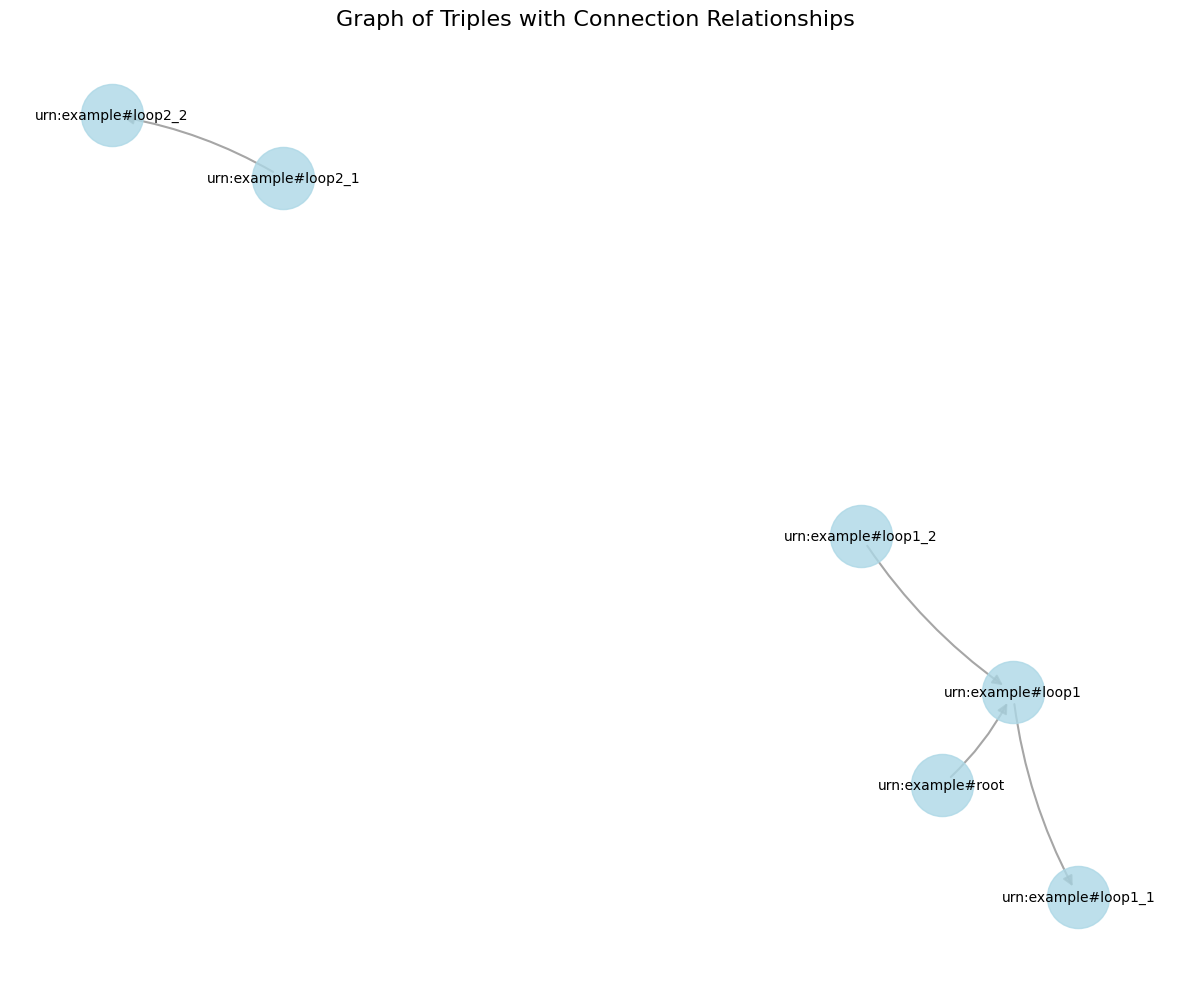

In [141]:
fig =visualize_triples(b_data)

ns_prefix s223
getting triples
building query
running query
getting results to list
converting to dataframe
took 0.001390218734741211 seconds
finding overlapped columns
finding sets from pairs
getting_relations
completed getting relations
serializing grouping
[<Variable value=root>]
serializing grouping
[<Variable value=loop1>, <Variable value=loop2>]
serializing grouping
[<Variable value=root>]
serializing grouping
[<Variable value=loop1>, <Variable value=loop2>]
serializing grouping
[<Variable value=loop1>, <Variable value=loop2>]
serializing grouping
[<Variable value=loop1_1>, <Variable value=loop2_1>]
serializing grouping
[<Variable value=loop1>, <Variable value=loop2>]
serializing grouping
[<Variable value=loop1_1>, <Variable value=loop2_1>]
serializing grouping
[<Variable value=loop1_1>, <Variable value=loop2_1>]
serializing grouping
[<Variable value=loop1_2>, <Variable value=loop2_2>]
serializing grouping
[<Variable value=loop1_1>, <Variable value=loop2_1>]
serializing grouping


[[(<Variable value=loop1>, <Variable value=loop2>),
  (<Variable value=loop1_2>, <Variable value=loop2_2>),
  (<Variable value=loop1_1>, <Variable value=loop2_1>),
  <Variable value=root>],
 [<Variable value=loop1_1_loop2_1>,
  <Variable value=loop1_2_loop2_2>,
  <Variable value=loop1_loop2>,
  <Variable value=root>],
 [<Variable value=loop1_1_loop2_1>,
  <Variable value=loop1_2_loop2_2>,
  <Variable value=loop1_loop2>,
  <Variable value=root>]]

[{'root': [<Variable value=root>],
  'loop1_loop2': [<Variable value=loop1>, <Variable value=loop2>],
  'loop1_1_loop2_1': [<Variable value=loop1_1>, <Variable value=loop2_1>],
  'loop1_2_loop2_2': [<Variable value=loop1_2>, <Variable value=loop2_2>]},
 {'loop1_2_loop2_2': [<Variable value=loop1_2_loop2_2>],
  'loop1_loop2': [<Variable value=loop1_loop2>],
  'loop1_1_loop2_1': [<Variable value=loop1_1_loop2_1>],
  'root': [<Variable value=root>]}]

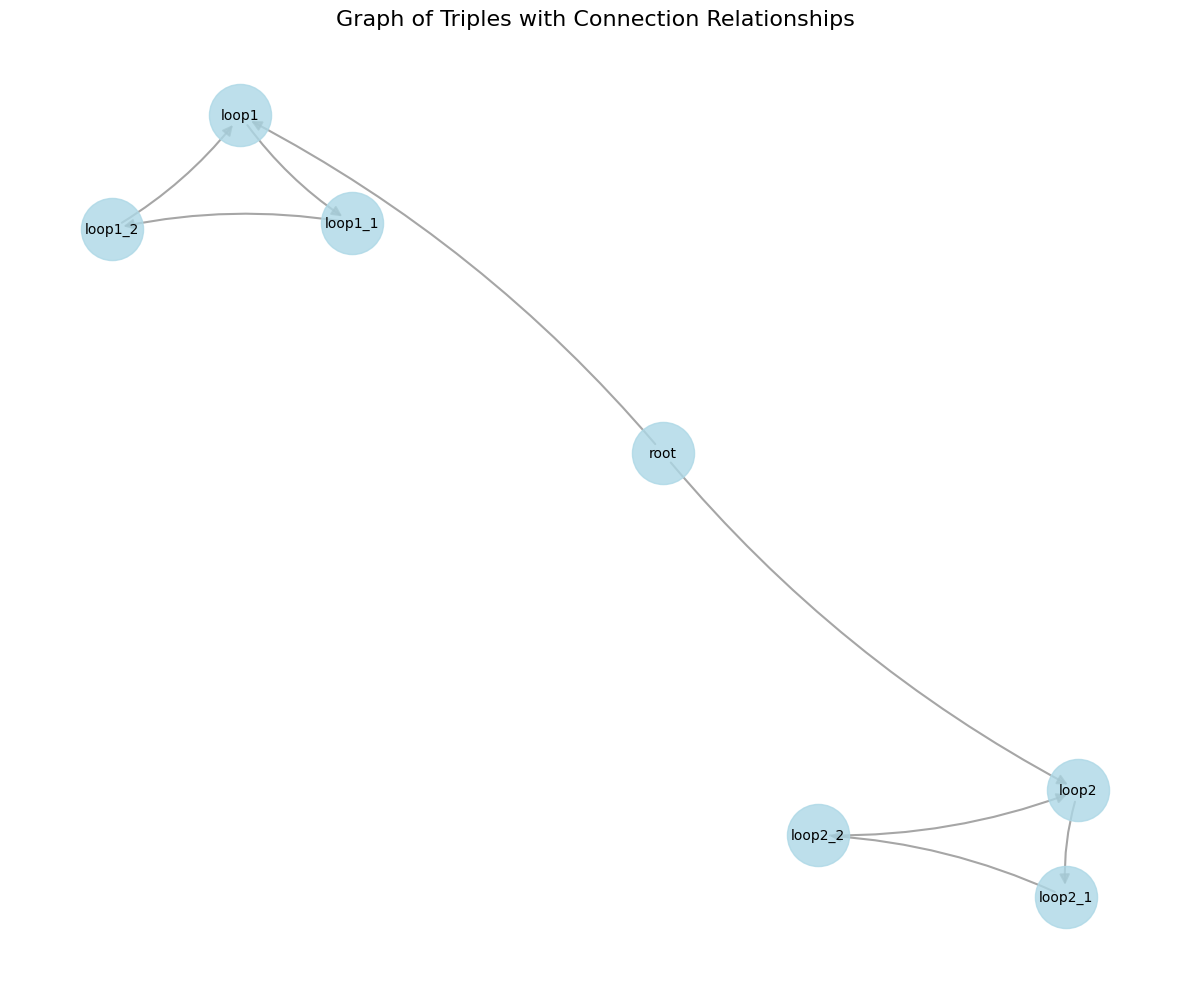

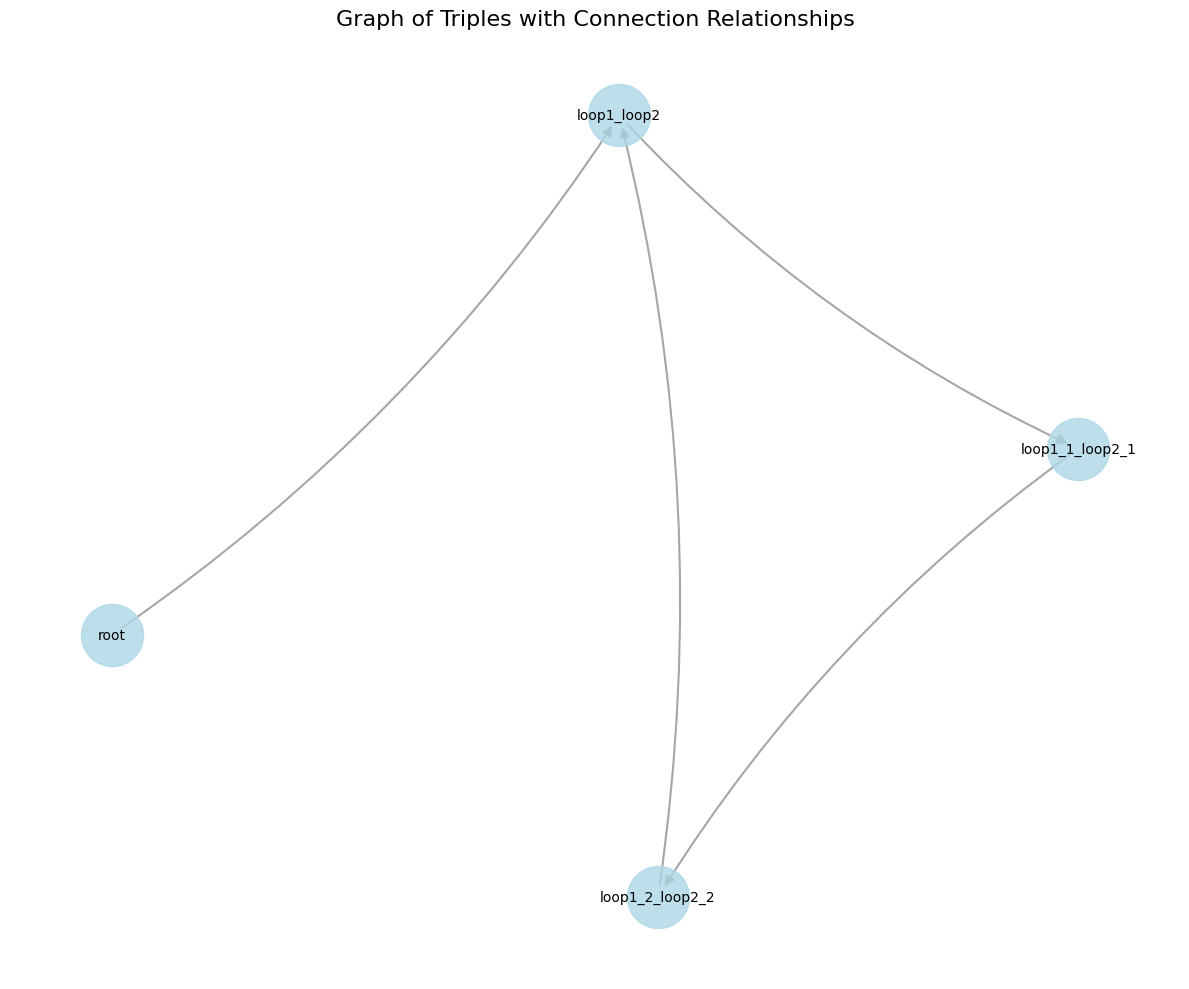

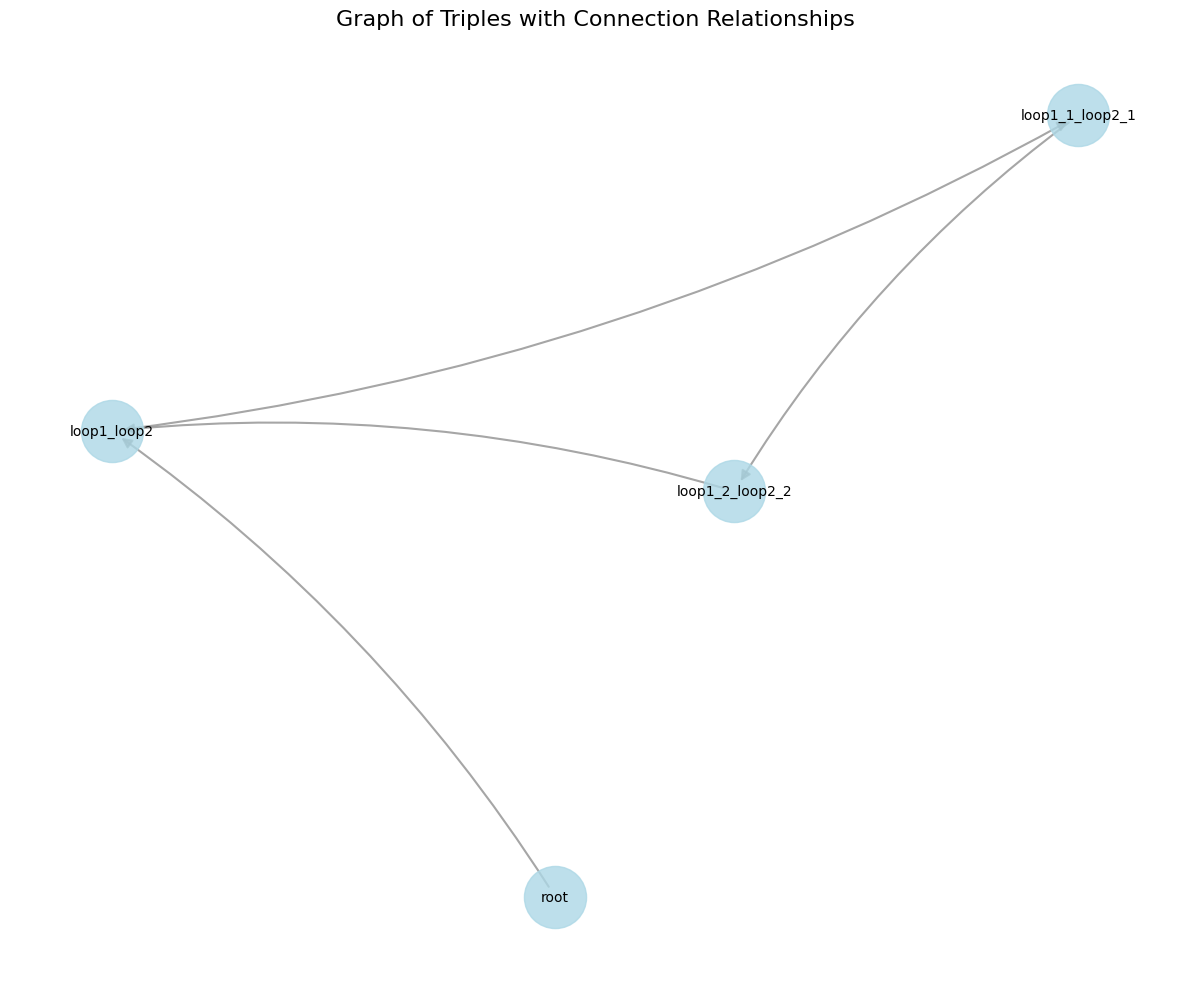

In [116]:
from group_nodes import GraphPatternProcessor

processor = GraphPatternProcessor(test_graph_file=TEST_GRAPH_FILE, 
                schema_graph_file=SCHEMA_GRAPH_FILE, 
                namespace=S223)

# Process and visualize
all_p, all_sets, group_dicts = processor.process_and_visualize(exempt_predicates=[])

In [142]:
print(final_query)

PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX ssn: <http://www.w3.org/ns/ssn/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX vann: <http://purl.org/vocab/vann/>
PREFIX void: <http://rdfs.or

In [146]:
print(query_to_df(final_query, g).to_markdown())

|    | loop1             | loop1_1             | loop1_2             | loop2_1             | loop2_2             | root             |
|---:|:------------------|:--------------------|:--------------------|:--------------------|:--------------------|:-----------------|
|  0 | urn:example#loop2 | urn:example#loop2_1 | urn:example#loop2_2 | urn:example#loop1   | urn:example#loop1_1 | urn:example#root |
|  1 | urn:example#loop2 | urn:example#loop2_1 | urn:example#loop2_2 | urn:example#loop1_1 | urn:example#loop1_2 | urn:example#root |
|  2 | urn:example#loop2 | urn:example#loop2_1 | urn:example#loop2_2 | urn:example#loop1_2 | urn:example#loop1   | urn:example#root |
|  3 | urn:example#loop1 | urn:example#loop1_1 | urn:example#loop1_2 | urn:example#loop2   | urn:example#loop2_1 | urn:example#root |
|  4 | urn:example#loop1 | urn:example#loop1_1 | urn:example#loop1_2 | urn:example#loop2_1 | urn:example#loop2_2 | urn:example#root |
|  5 | urn:example#loop1 | urn:example#loop1_1 | urn:example#l